# in this notebook we will run some exepriements to figure out what the benchmark design should be.

## Experiment 1: what context to include
We have filtered the dataset into documents that work with wgpu (at least naga), are permissively licenses, and extract functions that contain both a comment directly before as well as a docstring directly at the top of the function body.
we compare the four scenarios:
- comment + header
- comment + header + docstring (both)
- header + docstring
- header (none)
it's 4x150 generations. We will use deepseek-coder (1.3b or 6.7b) as that showed promising signs before.

This notebook will just run generations - the postprocessing might be done externally (like here? https://github.com/Vipitis/bigcode-evaluation-harness/tree/shadereval)
or we throw something together tomorrow.

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, StopStringCriteria
from accelerate import Accelerator
from datasets import load_dataset
from torch import bfloat16

from tqdm.auto import tqdm

accelerator = Accelerator()
device = accelerator.device
print(device)

experiment_ds = load_dataset("Vipitis/Shadereval-experiments-dev")# , download_mode="force_redownload")
experiment_ds = experiment_ds["train"] if "train" in experiment_ds else experiment_ds #unpack if DatasetDict?
# model_id = "deepseek-ai/deepseek-coder-6.7b-base"
model_id = "deepseek-ai/deepseek-coder-1.3b-base"
# model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
# tokenizer = AutoTokenizer.from_pretrained(model_id)
stop_words = ["\nfloat", "\nvec", "\nint", "\nmat"] # should cover the really common cases to speed things up.

# TODO: do we continue to use do_sample=False, because that has a huge impact on quality? -> more experiments
# careful about the do_sample setting here, I changed it to True for a little speed comparison - but no luck.
pipe = pipeline("text-generation", model=model_id, tokenizer=model_id, do_sample=False, stop_strings=stop_words, return_full_text=False, max_new_tokens=512, num_return_sequences=1, torch_dtype='bfloat16', device_map="auto")


cuda


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
m = 0
k = 257
k = min(len(experiment_ds["train"])-m, k+m)
generations = {}
for experiment in tqdm(["input_both", "input_comment", "input_docstring", "input_none"]):
    gen_list = []
    for row in tqdm(experiment_ds["train"].select(range(m,k))): # 10 just to test this locally...

        gens = pipe(row[experiment], max_new_tokens=512, num_return_sequences=1, tokenizer=tokenizer)
        generated_text = gens[0]["generated_text"]
        # inputs = tokenizer(row[experiment], return_tensors="pt").to(device)
        # generation = model.generate(**inputs, max_length=512, num_return_sequences=1, do_sample=False, stop_strings=stop_words, tokenizer=tokenizer, return_full_text=False)
        # generated_text = tokenizer.decode(generation[0], skip_special_tokens=True)
        gen_list.append(generated_text)
    generations[experiment] = gen_list

# is an 1.3b model really ~10tok/s for me on A750? that seems really slow - maybe I am doing it wrong... it could also be caching in a bit. I updated transformers and acclelerate.
# seems like stop_words don't work on xpu?
generations

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


KeyboardInterrupt: 

In [ ]:
# alternative variant where we use the pipeline as an iterator
from transformers.pipelines.pt_utils import KeyDataset
gens = {}
for experiment in tqdm(["input_both", "input_comment", "input_docstring", "input_none"]): # need to just run input_none again!
    exp_gens = []
    for out in tqdm(pipe(KeyDataset(experiment_ds, experiment), tokenizer=tokenizer, max_new_tokens=512, num_return_sequences=1)):
        exp_gens.append(out)
    with open(f"exp1_v02_{len(experiment_ds)}_{experiment}.json", "w", encoding="utf-8") as outfile:
        json.dump({experiment:exp_gens}, outfile)

import json
with open(f"exp1_gens_{len(experiment_ds)}.json", "w", encoding="utf-8") as outfile2:
    json.dump(generations, outfile2)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

In [ ]:
# save the generations to a file
import json
with open(f"exp1_generations_{m}-{k}.json", "w", encoding="utf-8") as outfile:
    json.dump(generations, outfile)

In [ ]:
# load_generations and references
import json
from datasets import load_dataset

experiment_ds = load_dataset("Vipitis/Shadereval-experiments-dev")# , download_mode="force_redownload")
df = experiment_ds["train"].to_pandas()

with open("exp1_generations_0-150.json", "r", encoding="utf-8") as infile:
    generations = json.load(infile)



In [ ]:
# step 1. parse for valid function in (input+generation)
from annotate import parse_functions

for k,v in generations.items():
    df[f"gen_{k}"] = v

In [ ]:
# step 2 clean up and insert the generations into the code as alternatives.

def truncate_function(model_inp, model_pred):
    combined = model_inp + model_pred
    functions = parse_functions(combined)
    if functions == []:
        return model_pred + "// incomplete generation! \n"
    # print(f"{len(functions)} functions found: {functions}")
    num_bytes_inp = len(bytes(model_inp, encoding="utf-8"))
    first_function = functions[0]
    end_first_function = first_function[4]
    cleaned_pred = bytes(model_pred, encoding="utf-8")[:end_first_function-num_bytes_inp]
    return cleaned_pred.decode(encoding="utf-8")

def replace_body(row, altered_body):
    start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
    full_code = bytes(row["full_code"], encoding="utf-8")
    altered_body_bytes = bytes(altered_body, encoding="utf-8")
    altered_code = full_code[:end_docstring] + altered_body_bytes + full_code[end_function:] #might miss the docstring at times...
    return altered_code.decode(encoding="utf-8")

In [ ]:

for k in generations.keys():
    df[f"gen_{k}_truncated"] = df.apply(lambda x: truncate_function(x[k], x[f"gen_{k}"]), axis=1)

for k in generations.keys():
    df[f"{k}_altered"] = df.apply(lambda x: replace_body(x, x[f"gen_{k}_truncated"]), axis=1)

df.head()

,id,comment,header,docstring,body,full_code,func_bytes,has_comment,has_docstring,model_ctx,...,gen_input_docstring,gen_input_none,gen_input_both_truncated,gen_input_comment_truncated,gen_input_docstring_truncated,gen_input_none_truncated,input_both_altered,input_comment_altered,input_docstring_altered,input_none_altered
0,4sXXRN,//============================================...,float map( in vec3 p )\n{,\n // triangle\t,"\n\tvec3 v1 = 1.5*cos( iTime + vec3(0.0,1.0,1....",// The MIT License\n// Copyright © 2014 Inigo ...,"[2655, 2712, 2736, 2753, 3040]",True,True,//============================================...,...,"\n vec3 p0 = vec3( 0.0, 0.0, 0.0 );\n ve...",\n vec3 q = p;\n vec3 r = p;\n float ...,\n vec3 q = p - vec3( 0.5 );\n float d =...,"\n float a = atan( p.y, p.x ) / 3.141592653...","\n vec3 p0 = vec3( 0.0, 0.0, 0.0 );\n ve...",\n vec3 q = p;\n vec3 r = p;\n float ...,// The MIT License\n// Copyright © 2014 Inigo ...,// The MIT License\n// Copyright © 2014 Inigo ...,// The MIT License\n// Copyright © 2014 Inigo ...,// The MIT License\n// Copyright © 2014 Inigo ...
1,4dSXDd,// This is the big money function that makes t...,float DistanceToObject(vec3 p)\n{,"\n //p += (1.0/p.y)*0.6;\n\n // Rotate, ...","\n if (dot(p, rotDir) > 1.0) p *= rotMat;\n...",/*--------------------------------------------...,"[4341, 4412, 4444, 4534, 6672]",True,True,// This is the big money function that makes t...,...,"\n vec3 rotated = Rotate(p, rotDir);\n\n ...",\n float d = length(p - _position);\n re...,"\n vec3 q = Rotate(p, rotDir, rotSpeed);\n\...",\n float d = length(p);\n return d - 0.0...,"\n vec3 rotated = Rotate(p, rotDir);\n\n ...",\n float d = length(p - _position);\n re...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...
2,XllGzN,// Question - the derivative can be computed f...,"void mainImage( out vec4 fragColor, in vec2 fr...",\n\t//get coords and direction,\n\tvec2 uv=fragCoord.xy/iResolution.xy-.5;\n\...,// Started as Star Nest by Pablo RomÃ¡n Andrio...,"[1714, 2239, 2296, 2324, 4392]",True,True,// Question - the derivative can be computed f...,...,\n\tvec2 uv = fragCoord.xy / iResolution.xy;\n...,\n vec2 uv = fragCoord.xy / iResolution.xy;...,\n\tvec2 uv = fragCoord.xy / iResolution.xy;\n...,\n vec2 uv = fragCoord.xy / iResolution.xy;...,\n\tvec2 uv = fragCoord.xy / iResolution.xy;\n...,\n vec2 uv = fragCoord.xy / iResolution.xy;...,// Started as Star Nest by Pablo RomÃ¡n Andrio...,// Started as Star Nest by Pablo RomÃ¡n Andrio...,// Started as Star Nest by Pablo RomÃ¡n Andrio...,// Started as Star Nest by Pablo RomÃ¡n Andrio...
3,Xll3zM,// Created by inigo quilez - iq/2013\n// Licen...,vec4 juliaSet(vec2 p)\n{,\n //p = p * 2.0 - 1.0;\n //p = p / ((p....,\n \n vec2 cc = 1.1*vec2( 0.5*cos(0.1*iT...,//\n// Description : Array and textureless GLS...,"[3306, 3431, 3454, 3659, 4271]",True,True,// Created by inigo quilez - iq/2013\n// Licen...,...,\n\n vec2 cc = vec2( 1.5*cos(0.1*iTime) - 0...,\n vec4 color = vec4(0.0);\n vec2 z = p;...,"\n\n vec2 cc = vec2(0.5, 0.5);\n\n vec2 ...",\n vec4 color = vec4(0.0);\n vec2 z = p;...,\n\n vec2 cc = vec2( 1.5*cos(0.1*iTime) - 0...,\n vec4 color = vec4(0.0);\n vec2 z = p;...,//\n// Description : Array and textureless GLS...,//\n// Description : Array and textureless GLS...,//\n// Description : Array and textureless GLS...,//\n// Description : Array and textureless GLS...
4,XljGDz,// This is a procedural environment map with a...,"vec3 GetEnvColor2(vec3 rayDir, vec3 sunDir)\n{",\n // fade bottom to top so it looks like t...,"\n vec3 final = vec3(1.0) * dot(-rayDir, su...",/*--------------------------------------------...,"[1619, 1752, 1797, 1910, 2596]",True,True,// This is a procedural environment map with a...,...,and forth\n float fade = clamp(0.5 - dot(r...,"\n float cosTheta = dot(rayDir, sunDir);\n ...",and forth\n float fade = clamp(0.

In [ ]:
# simple lexer via tree-sitter?

# simple lexer?
import tree_sitter

def get_leaves(subtree: tree_sitter.Node, skip_comments: bool=False, rename_identifiers: bool=False) -> list[str]:
    # TODO: add like a wrapper function to give the root node initially...
    tokens = []
    if subtree.child_count == 0:
        if subtree.type == "comment" and skip_comments:
            pass
        elif subtree.type == "identifier" and rename_identifiers:
            # TODO: what about different name spaces - where do we hand this upwards?
            # do we need to like return our mapping to get different placeholders?
            return [f"id"]
        else:
            return [subtree.text]
    else:
        for child in subtree.children:
            tokens.extend(get_leaves(child, skip_comments, rename_identifiers))
    return tokens

# exact_tokens = get_leaves(tree.root_node, skip_comments=False)
# lexical_tokens = get_leaves(tree.root_node, skip_comments=True)
# syntax_tokens = get_leaves(tree.root_node, True, True)
# print(len(exact_tokens))
# print(len(lexical_tokens))
# print(len(syntax_tokens))

# tree.root_node.children[3].children[1].children[0].text
# syntax_tokens

In [ ]:
# takes 64 seconds on laptop

from annotate import run_shader, PARSER

def compare_shaders(reference, prediction):
    if reference == prediction:
        return "c0-clone" #exact match
    if "// incomplete generation! \n" in prediction:
        return "generation error" # ususally the a loop
    ref_tree = PARSER.parse(bytes(reference, encoding="utf-8"))
    pred_tree = PARSER.parse(bytes(prediction, encoding="utf-8"))
    ref_lex_tokens = get_leaves(ref_tree.root_node, True)
    pred_lex_tokens = get_leaves(pred_tree.root_node, True)
    if ref_lex_tokens == pred_lex_tokens:
        return "c1-clone" #lexical similarity: differences in comments and white spaces only
    ref_syn_tokens = get_leaves(ref_tree.root_node, True, True)
    pred_syn_tokens = get_leaves(pred_tree.root_node, True, True)
    if ref_syn_tokens == pred_syn_tokens:
        return "c2-clone*" #almost syntactic similarity. our identifier replacement isn't perfect yet
    else:
        return exec_shader(prediction)
    # else:
    #     return "other"


# copied from BigCode, but they might have copied this from OpenAI - it's MIT. https://github.com/bigcode-project/bigcodebench/blob/main/bigcodebench/eval/utils.py https://github.com/bigcode-project/bigcode-evaluation-harness/blob/main/bigcode_eval/tasks/custom_metrics/execute.py#L90
import contextlib
import signal
@contextlib.contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise RuntimeError("Timed out!")

    signal.setitimer(signal.ITIMER_REAL, seconds) # only works on unix -.- need to find something else I guess.
    signal.signal(signal.SIGALRM, signal_handler)
    try:
        yield
    finally:
        signal.setitimer(signal.ITIMER_REAL, 0)

from wgpu_shadertoy import Shadertoy
def exec_shader(shader_code):
    run_program = "shader = Shadertoy(shader_code, offscreen=True)"
    try:
        with time_limit(10):
            exec(run_program)
        return "ok"
    except RuntimeError as e:
        return "timeout"
    except Exception as e:
        return "error"

def run_comparison(row, k):
    # print(row)
    ref = row["full_code"]
    pred = row[f"{k}_altered"]
    return compare_shaders(ref, pred)

for k in generations.keys():
    df[f"{k}_comp"] = df.apply(run_comparison, axis=1,k=k)
    print(df[f"{k}_comp"].value_counts())

input_both_comp
error               86
generation error    63
c1-clone             1
Name: count, dtype: int64
input_comment_comp
error               104
generation error     46
Name: count, dtype: int64
input_docstring_comp
generation error    78
error               70
c1-clone             2
Name: count, dtype: int64
input_none_comp
error               91
generation error    59
Name: count, dtype: int64


In [ ]:
with time_limit(10):
    print(1.3 * 55555)

AttributeError: module 'signal' has no attribute 'setitimer'

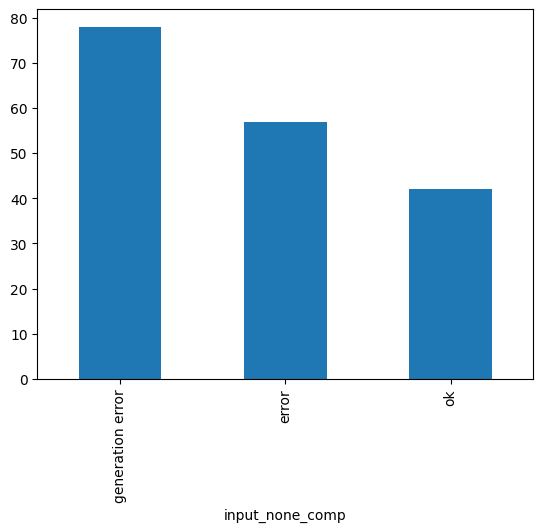

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
for k in generations.keys():
    # plot each experiment as a stacked bar of the different labels
    df[f"{k}_comp"].value_counts().plot(kind="bar", stacked=True)

In [ ]:
# so apparently the cell below crashes the notebook when getting to the row with index "ttcXD2" for our first experiment - both... let's investigate.
# index 90 in the df

print(df.loc[90,:])

id                                                                          ttcXD2
comment                          // A moving ball in 3D space. Motion blurred b...
header                           float SphereIntersect(Ray r, vec3 center, floa...
docstring                                                \n    // geometric method
body                             \n    vec3 L = center - r.origin;\n    float d...
full_code                        // The MIT License\n// Copyright © 2020 Ridge/...
func_bytes                                          [1083, 1590, 1647, 1671, 2345]
has_comment                                                                   True
has_docstring                                                                 True
model_ctx                        // A moving ball in 3D space. Motion blurred b...
needed                                                                        True
status                                                                       valid
inpu

In [ ]:
from wgpu_shadertoy import Shadertoy

shader = Shadertoy(df.loc[90,"full_code"], offscreen=True)
snap = shader.snapshot(10.0)

: 

In [ ]:
# step 3. run evaluations!
from evaluate import load
shadermatch = load("Vipitis/shadermatch")

exp1_scores = {}

fields = ["text_match", "code_error", "image_match", "single_color", "incomplete_generation"]

for k in generations.keys():
    print(k)
    scores = []
    for row in df.iterrows():
        if row[1][f"{k}_altered_valid"] != "valid":
            single_score = {"code_error" : 1.0}
        else:
            print(row[1]["id"])
            single_score = shadermatch.compute(references=[row[1]["full_code"]], predictions=[row[1][f"{k}_altered"]])
        scores.append(single_score)
    scores = {k: sum([x.get(k, 0.0) for x in scores])/len(scores) for k in fields}
    scores["variations"] = 1 - sum(scores.values())
    exp1_scores[k] = scores
    print(scores)

input_both
4sXXRN
Xll3zM
Xd3SRj
XlcSz2
MtcXRf
llGSzw
lsffDS
Md2BWW
4lByzR
4styzM
lsyfWc
MdKBWt
llGyzh
Mtyyzh
4tKBRy
MtKyD1
MtKyD1
MtKyD1
3d2GRh
3dB3RD
tsj3zw
MldfWn
tdS3DG
tdjSD1
WtB3Wt
wlBXWK
ttcXD2


## Experiment 2: Do we include the main function as a 1-shot task?
Motivation: LiveCodeBench does 1-shot for base models, this might help them understand the language that is used (via syntax clues), and also gives them an idea on whats available outside of the context we provide.
every shader will have a main function, and we likely don't want to generate them anyways...
the dataset for this is not prepared. But it would be only non main functions, and we have an additional columns in the dataset for the main function (or at least it's start-byte, as there should be nothing past it).
open questions: do we add comments to explain this? do we list the function names for all other stuff available (and later down also in common tab?)
main issue: the mainImage function is at the bottom, we would mess up the order. Not too bad for transformers as it's all parallel and they might not understand this strict definition... we have to see the results.

alternative: give the model the whole context- but context length will be a problem, FIM is likely the goal - but not all models support that.

In [ ]:
# TODO: implement this experiment (but prepare the data first).

## Experiment 3: do_sample True or False? also what generation parameters
this is motivated by observations.
